In [1]:
#meta 1/17/2020 Kaggle Cassava Data
#fast.ai 2020 study group Kaggle Competition
#src https://www.kaggle.com/c/cassava-leaf-disease-classification
#prev competition src https://www.kaggle.com/c/cassava-disease
#references https://arxiv.org/pdf/1908.02900.pdf

#input: kaggle files - images, csv with 5 cats
#output: data artifacts for next step 2-model
#pwd: /kaggle/working
#based on my-kaggle-cassava-1-model.ipynb

#history
#1/4/2021 DATA - IMBALANCED DS -> STRATIFIED VALIDATION SET
#      dataprep delta: Stratified data split
#      src https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html
#      dataprep delta: add df_train['is_valid'] column needed for ColSplitter()
#      src https://docs.fast.ai/tutorial.datablock.html

#1/17/2021 DATA MODULE, ORIGINAL TRAIN DS AND OVERSAMPLED TRAIN DS
#      With Stratified data split
#      Imbalanced dataset -> oversample
#      Export train datasets. $param

#2/7/2020 DATA MODULE, ORIGINAL TRAIN DS AND OVERSAMPLED TRAIN DS
#      With Stratified data split
#      Imbalanced dataset -> manual oversample
#      2 versions: full and mini for rapid iteration (10%) $param

#here 2/7/2020 DATA MODULE, K-FOLD STRATIFIED SPLIT
#      Original full ds and oversampled ds, with Stratified data split
#      Imbalanced dataset -> manual oversample
#      2 versions: full and mini for rapid iteration (10%) $param


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import os
import time #to track performance time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#stratified split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

#modeling
from fastai.vision.all import *


# Input data files are available in the read-only "../input/" directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
#--constants and variables
SEED = 24
MINI_FLG = 0 #$param
MINI_DS_SIZE = 0.1
VALID_DS_SIZE = 0.2

path = Path('../input/cassava-leaf-disease-classification')

#--functions
#define label lookup 
def lookup_label(image_id): return int(df_train[df_train['image_id']== image_id]['label'])

#test function
#lookup_label('100042118.jpg')

# Cassava Data
21397 train images and 1 test image

## 0. Load Data
- input images
- output labels
- train dataset

In [4]:
path.ls()

(#7) [Path('../input/cassava-leaf-disease-classification/train_tfrecords'),Path('../input/cassava-leaf-disease-classification/sample_submission.csv'),Path('../input/cassava-leaf-disease-classification/test_tfrecords'),Path('../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'),Path('../input/cassava-leaf-disease-classification/train_images'),Path('../input/cassava-leaf-disease-classification/train.csv'),Path('../input/cassava-leaf-disease-classification/test_images')]

In [5]:
(path/'train_images').ls(), (path/'test_images').ls()

((#21397) [Path('../input/cassava-leaf-disease-classification/train_images/1235188286.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/1215607589.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/478554372.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/2763304605.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/2826122413.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/111117998.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/231268038.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/4201965605.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/3224710052.jpg'),Path('../input/cassava-leaf-disease-classification/train_images/1290729293.jpg')...],
 (#1) [Path('../input/cassava-leaf-disease-classification/test_images/2216849948.jpg')])

In [6]:
#load train/test images
#train_img = get_image_files(path/'train_images')
#test_img = get_image_files(path/'test_images')

#print("Number of files: ", (len(train_img), len(test_img)))

In [7]:
#labels
with open((path/'label_num_to_disease_map.json')) as json_file:
    target_map = json.load(json_file)
    
print(target_map)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


In [8]:
#train Dataset
df_train = pd.read_csv(path/'train.csv')

df_train['k_fold'] = None

print('train data\n', df_train.shape)
display(df_train.head())


train data
 (21397, 3)


,image_id,label,k_fold
0,1000015157.jpg,0,None
1,1000201771.jpg,3,None
2,100042118.jpg,1,None
3,1000723321.jpg,1,None
4,1000812911.jpg,3,None


## 1. Prep Data
### 1.1 Full or Mini dataset

In [9]:
#train mini subsample for rapid iteration
if MINI_FLG:
    #stratified subsample
    X_mini = df_train['image_id']
    y_mini = df_train['label']
    sss_mini = StratifiedShuffleSplit(n_splits=1, test_size=MINI_DS_SIZE, random_state=SEED)
    
    for train_idx_mini, valid_idx_mini in sss_mini.split(X_mini, y_mini):
        print("TRAIN:", train_idx_mini, "VALID:", valid_idx_mini)
        y_train_mini, y_valid_mini = y_mini[train_idx_mini], y_mini[valid_idx_mini]

    y_train_mini.value_counts().sort_index()
    y_train_mini.value_counts().sort_index().plot(kind='bar');
    

In [10]:
#train subsample
if MINI_FLG:
    #update df_train with train index 
    df_train = df_train.loc[df_train.index.isin(valid_idx_mini)].reset_index()
    print(df_train.shape)
    print(df_train.head())
    

0     1087
1     2189
2     2386
3    13158
4     2577
Name: label, dtype: int64


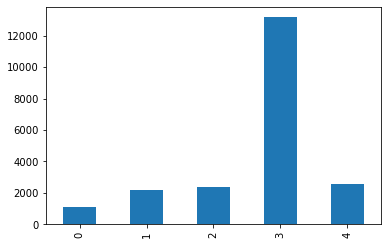

In [11]:
print(df_train['label'].value_counts().sort_index())
df_train['label'].value_counts().sort_index().plot(kind='bar');

### 1.2 K-fold Stratified Split
Stratified K-Folds cross-validator.

Provides train/test indices to split data in train/test sets.  This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [12]:
if MINI_FLG:
    X = df_train[['index', 'image_id', 'k_fold']]
else:
    X = df_train[['image_id', 'k_fold']]
y = df_train['label']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
skf.get_n_splits(X, y)
print(skf)


KeyError: "['index'] not in index"

In [ ]:
k_fold = 0

for train_idx, valid_idx in skf.split(X, y):
    #print("TRAIN:", train_idx, "\nVALID:", valid_idx)
     
    #update df_train with k-fold i
    df_train.loc[(df_train.index.isin(valid_idx)), 'k_fold'] = k_fold
    
    k_fold+=1

#preview df with k-fold index
df_train[::200]

In [ ]:
#k-fold counts
df_train.groupby('k_fold').count()

In [ ]:
#export data
if MINI_FLG:
    torch.save(df_train, 'df_train_mini_kfold.pkl')
else:
    torch.save(df_train, 'df_train_kfold.pkl')